<a href="https://www.kaggle.com/code/aletbm/diabetes-ensemble-vs-individual-learners?scriptVersionId=140945570" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🧬 Diabetes (Ensemble vs Individual Learners)


<img src="https://images.pexels.com/photos/6942015/pexels-photo-6942015.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1">


In [1]:
!pip install mplcyberpunk
!pip install sdv
!pip install graphviz >= 0.13.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.9.1 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.20.1 which is incompatible.
ERROR: Could not find a version that satisfies the requirement 0.13.2 (from versions: n

# 🗃️ Loading packages

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-data-set/diabetes.csv


In [3]:
from sklearn.preprocessing import QuantileTransformer ,StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, 
                        precision_score, recall_score, f1_score, 
                        plot_roc_curve, plot_precision_recall_curve,
                        accuracy_score, classification_report)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skewtest, kurtosistest, normaltest, norm

from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from imblearn.over_sampling import SMOTE, ADASYN

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import mplcyberpunk

plt.style.use("cyberpunk")
np.random.seed(42)

# 💾 About Dataset

## Context

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective is to predict based on diagnostic measurements whether a patient has diabetes.

## Content

Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

+ Pregnancies: Number of times pregnant
+ Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
+ BloodPressure: Diastolic blood pressure (mm Hg)
+ SkinThickness: Triceps skin fold thickness (mm)
+ Insulin: 2-Hour serum insulin (mu U/ml)
+ BMI: Body mass index (weight in kg/(height in m)^2)
+ DiabetesPedigreeFunction: Diabetes pedigree function
+ Age: Age (years)
+ Outcome: Class variable (0 or 1)

## Past Usage
```
1. Smith,~J.~W., Everhart,~J.~E., Dickson,~W.~C., Knowler,~W.~C., \&
   Johannes,~R.~S. (1988). Using the ADAP learning algorithm to forecast
   the onset of diabetes mellitus.  In {\it Proceedings of the Symposium
   on Computer Applications and Medical Care} (pp. 261--265).  IEEE
   Computer Society Press.

   The diagnostic, binary-valued variable investigated is whether the
   patient shows signs of diabetes according to World Health Organization
   criteria (i.e., if the 2 hour post-load plasma glucose was at least 
   200 mg/dl at any survey  examination or if found during routine medical
   care).   The population lives near Phoenix, Arizona, USA.

   Results: Their ADAP algorithm makes a real-valued prediction between
   0 and 1.  This was transformed into a binary decision using a cutoff of 
   0.448.  Using 576 training instances, the sensitivity and specificity
   of their algorithm was 76% on the remaining 192 instances.
```
## Relevant Information
```
  Several constraints were placed on the selection of these instances from
  a larger database.  In particular, all patients here are females at
  least 21 years old of Pima Indian heritage.  ADAP is an adaptive learning
  routine that generates and executes digital analogs of perceptron-like
  devices.  It is a unique algorithm; see the paper for details.
```

## Loading data

In [4]:
df = pd.read_csv("../input/diabetes-data-set/diabetes.csv", sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


The first restriction that we must keep in mind is that the dataset is not so large as to discard samples so easily, so in cases of empties or unusual data we must keep in mind them and so search alternative preprocessing for this dataset without the need to delete them.

In [5]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

# 🕵️ Looking for null data and duplicated rows

<AxesSubplot:>

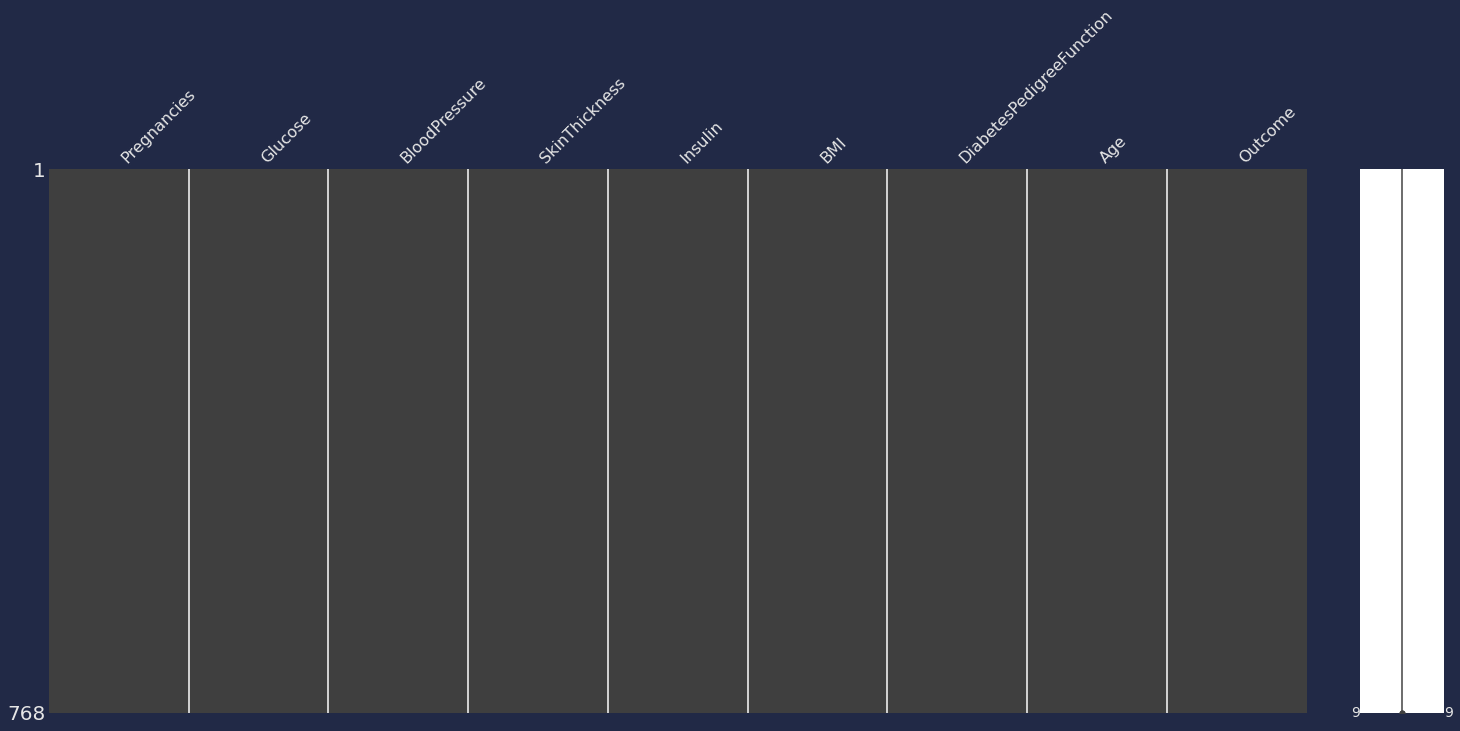

In [6]:
msno.matrix(df)

In [7]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

It is evident that there are no null data.

In [8]:
df.duplicated().sum()

0

# 🔎 Looking for outliers

<AxesSubplot:xlabel='Age'>

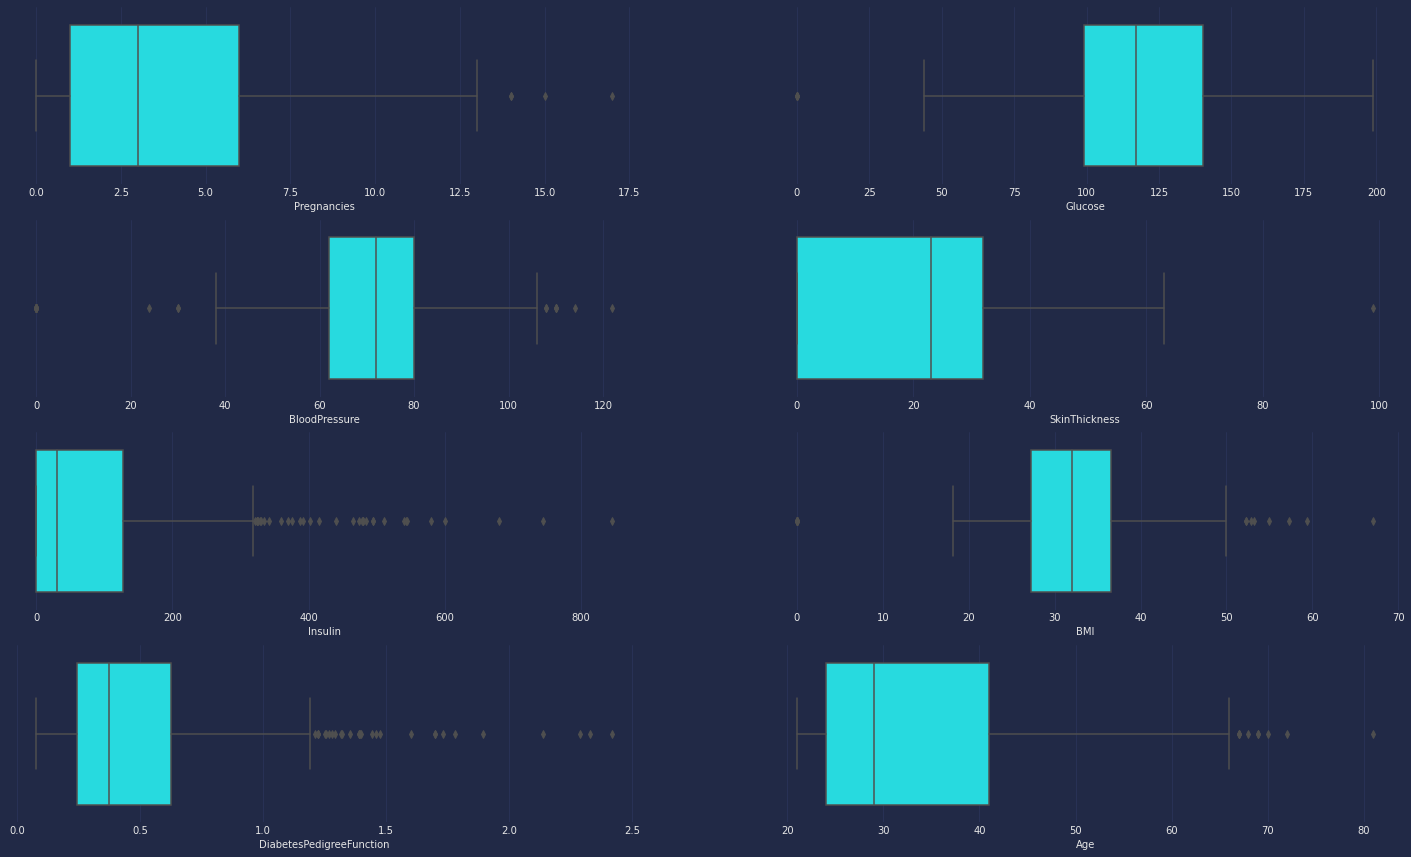

In [9]:
fig,axs = plt.subplots(4,2, figsize = (25,15))

sns.boxplot(data=df, x="Pregnancies", ax=axs[0, 0], hue='Outcome')
sns.boxplot(data=df, x="Glucose", ax=axs[0, 1], hue='Outcome')
sns.boxplot(data=df, x="BloodPressure", ax=axs[1, 0], hue='Outcome')
sns.boxplot(data=df, x="SkinThickness", ax=axs[1, 1], hue='Outcome')
sns.boxplot(data=df, x="Insulin", ax=axs[2, 0], hue='Outcome')
sns.boxplot(data=df, x="BMI", ax=axs[2, 1], hue='Outcome')
sns.boxplot(data=df, x="DiabetesPedigreeFunction", ax=axs[3, 0], hue='Outcome')
sns.boxplot(data=df, x="Age", ax=axs[3, 1], hue='Outcome')

In [10]:
df.describe().transpose()

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

In [11]:
def get_outliers(df, col, detection="mild", method="IQR", position="both"):
    Q1, Q3= df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    k = 1.5
    
    df_mean, df_std = df[col].mean(), df[col].std()
    n = 3
    
    if detection == "extreme":
        k = 3
        n = 4
    
    if method == "IQR":
        upper, lower = Q3 + IQR*k, Q1 - IQR*k
    else:
        upper, lower = df_std * n + df_mean, df_std * n - df_mean
        
    
    if position == "lower":
        mask = (df[col] <= lower)
    elif position == "upper":
        mask = (df[col] >= upper)
    else:
        mask = (df[col] <= lower) | (df[col] >= upper)
        
    return df[mask]

def table_outliers(df, columns, target="Outcome", alpha=0.05):
    df_olr = pd.DataFrame(columns=["Feature", "Normal Distribution", "P-value", "Skewness", "Kurtosis", "Detection method", "Mild Outliers", "Extreme Outliers"])
    
    for col in columns:
        skew, kurt = skewtest(df[col]), kurtosistest(df[col])
        stats, pvalue = normaltest(df[col])
        normality = False
        
        if pvalue > alpha:
            normality = True
            
        if normality == True and skew[1] > alpha:
            method = "STD"
            mild_out = get_outliers(df, col, "mild", "STD")
            extreme_out = get_outliers(df, col, "extreme", "STD")
        else:
            method = "IQR"
            mild_out = get_outliers(df, col, "mild", "IQR")
            extreme_out = get_outliers(df, col, "extreme", "IQR")
            
        df_new = pd.DataFrame(data={"Feature":[col],
                                    "Normal Distribution":[normality],
                                    "P-value": [pvalue],
                                    "Skewness":[skew[0]],
                                    "Kurtosis":[kurt[0]],
                                    "Detection method":[method],
                                    "Mild Outliers":[len(mild_out) - len(extreme_out)],
                                    "Extreme Outliers":[len(extreme_out)],
                                    "Percentage of outliers":[(len(mild_out))*100/len(df)]
                                   }
                             )
        df_olr = pd.concat((df_olr, df_new), axis=0, ignore_index = True)
    return df_olr

outliers = table_outliers(df, ["SkinThickness", "Glucose", "Age", "Pregnancies", "BMI", "DiabetesPedigreeFunction", "Insulin", "BloodPressure"], "Outcome", 0.05).sort_values(["Extreme Outliers", "Mild Outliers"], ascending=[False, False])
outliers

Feature Normal Distribution       P-value   Skewness  \
7             BloodPressure               False  3.780127e-67 -14.555871   
6                   Insulin               False  6.895343e-85  16.388118   
5  DiabetesPedigreeFunction               False  1.298770e-70  14.906939   
4                       BMI               False  1.969687e-19  -4.695064   
2                       Age               False  9.308980e-27  10.550440   
1                   Glucose               False  2.044651e-03   1.966493   
3               Pregnancies               False  3.914292e-18   8.904638   
0             SkinThickness               False  1.712416e-04   1.243197   

    Kurtosis Detection method Mild Outliers Extreme Outliers  \
7   9.696056              IQR            10               35   
6  10.909049              IQR            25                9   
5   9.981094              IQR            23                6   
4   8.006176              IQR            18                1   
2   2.926748              IQR             9                0   
1   2.918555              IQR             5                0   
3   0.933391              IQR             4                0   
0  -3.974837              IQR             1                0   

   Percentage of outliers  
7                5.859375  
6                4.427083  
5                3.776042  
4                2.473958  
2                1.171875  
1                0.651042  
3                0.520833  
0                0.130208

In [12]:
def get_normal_number(n, x0):
    x = np.arange(-x0, x0+1)
    xU, xL = x + 0.5, x - 0.5 
    prob = norm.cdf(xU, scale = np.std(x)) - norm.cdf(xL, scale = np.std(x))
    prob = prob / prob.sum()
    return np.abs(np.random.choice(x, size=n, p = prob))

def replace_outliers(df, columns, methods):
    df_ = df.copy()
    for col, mtd in zip(columns, methods):
        mild_upper = get_outliers(df=df_, col=col, method=mtd, detection="mild", position="upper")
        mild_lower = get_outliers(df=df_, col=col, method=mtd, detection="mild", position="lower")
        mild = get_outliers(df=df_, col=col, method=mtd, detection="mild")
        mean = df_[~df_.isin(mild)][col].mean()
        
        df_.loc[mild_upper.index.values, col] = mean + (get_normal_number(len(mild_upper), 20) if mean > 20 else 0)
        df_.loc[mild_lower.index.values, col] = mean - (get_normal_number(len(mild_lower), 20) if mean > 20 else 0)
        
    return df_

columns_outliers = outliers[outliers["Percentage of outliers"] > 1].Feature.values
methods = outliers[outliers["Percentage of outliers"] > 1]["Detection method"].values
df = replace_outliers(df, columns_outliers, methods)
df.describe().T

count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  120.894531  31.972618   0.000  99.00000   
BloodPressure             768.0   71.883331  11.405761  38.000  64.00000   
SkinThickness             768.0   20.536458  15.952218   0.000   0.00000   
Insulin                   768.0   62.729380  77.388995   0.000   0.00000   
BMI                       768.0   32.211818   6.523975  18.200  27.40000   
DiabetesPedigreeFunction  768.0    0.429832   0.244918   0.078   0.24375   
Age                       768.0   32.909173  11.110375  21.000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000   0.00000   

                               50%        75%      max  
Pregnancies                 3.0000    6.00000   17.000  
Glucose                   117.0000  140.25000  199.000  
BloodPressure              72.0000   80.00000  106.000  
SkinThickness              23.0000   32.00000   99.000  
Insulin                    30.5000  110.00000  318.000  
BMI                        32.0000   36.52500   50.000  
DiabetesPedigreeFunction    0.3725    0.58225    1.191  
Age                        29.0000   40.00000   66.000  
Outcome                     0.0000    1.00000    1.000

# 📽️ Data visualization

## Data exploration

<AxesSubplot:xlabel='Age', ylabel='Count'>

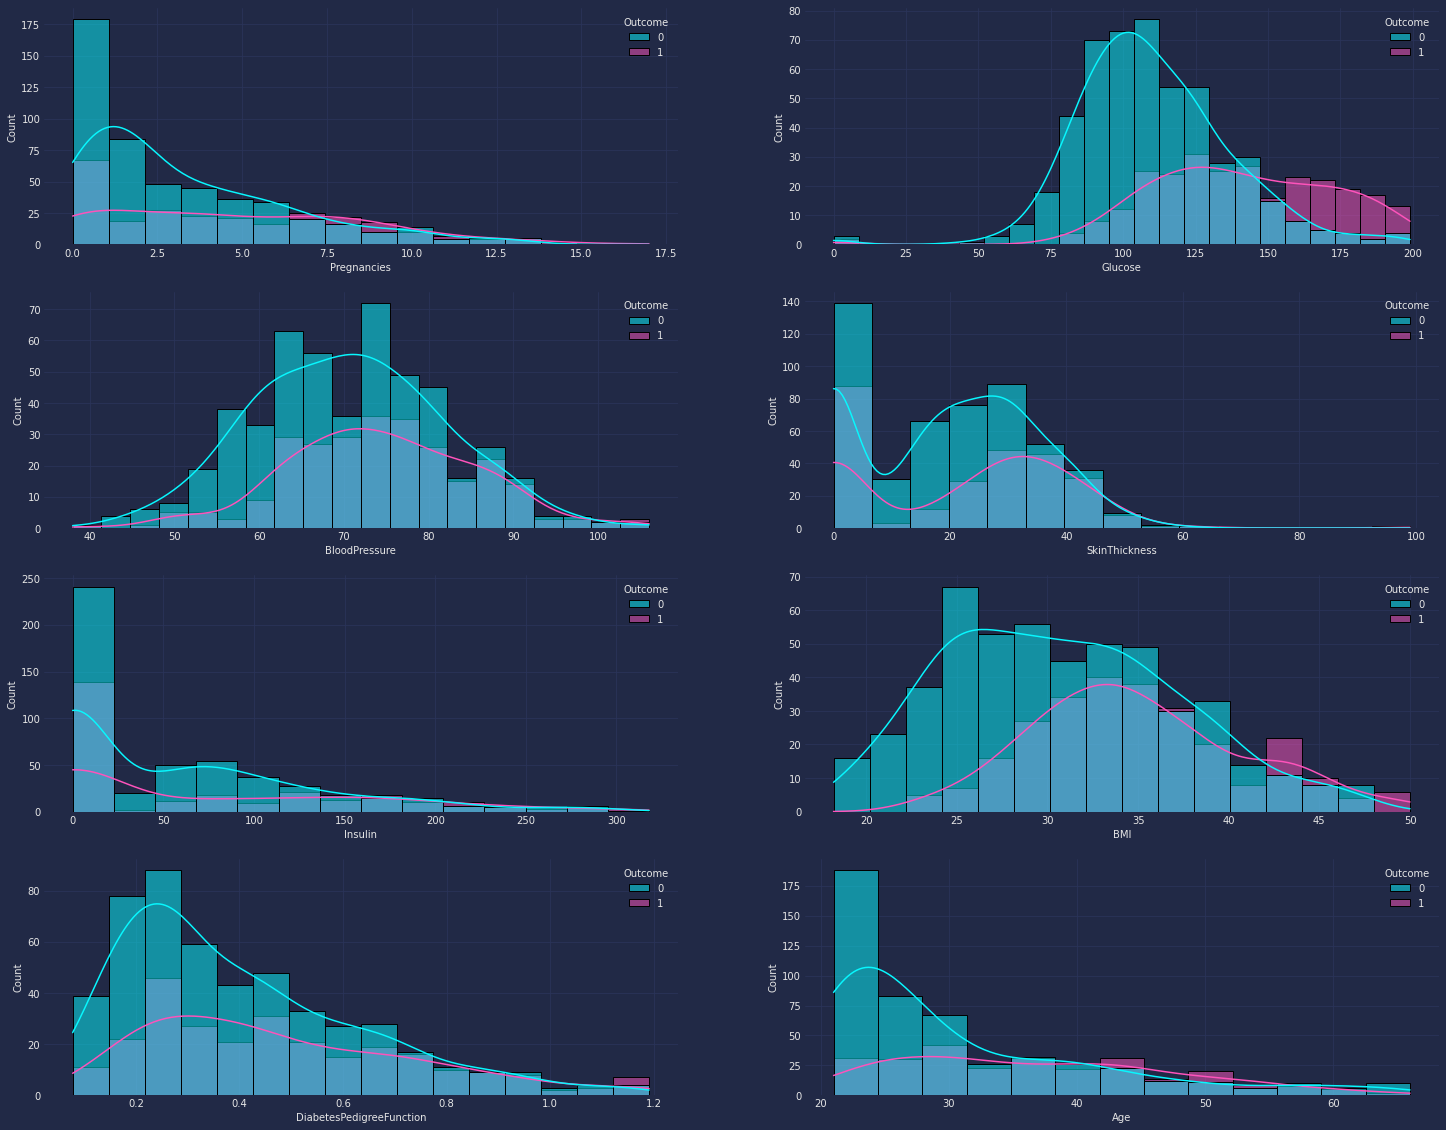

In [13]:
fig,axs = plt.subplots(4,2, figsize = (25,20))

sns.histplot(data=df, x="Pregnancies", kde=True, ax=axs[0, 0], hue='Outcome')
sns.histplot(data=df, x="Glucose", kde=True, ax=axs[0, 1], hue='Outcome')
sns.histplot(data=df, x="BloodPressure", kde=True, ax=axs[1, 0], hue='Outcome')
sns.histplot(data=df, x="SkinThickness", kde=True, ax=axs[1, 1], hue='Outcome')
sns.histplot(data=df, x="Insulin", kde=True, ax=axs[2, 0], hue='Outcome')
sns.histplot(data=df, x="BMI", kde=True, ax=axs[2, 1], hue='Outcome')
sns.histplot(data=df, x="DiabetesPedigreeFunction", kde=True, ax=axs[3, 0], hue='Outcome')
sns.histplot(data=df, x="Age", kde=True, ax=axs[3, 1], hue='Outcome')

As we can see some data has a large amount of null data, let's check it.

In [14]:
df.describe().transpose()

count        mean        std     min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000   1.00000   
Glucose                   768.0  120.894531  31.972618   0.000  99.00000   
BloodPressure             768.0   71.883331  11.405761  38.000  64.00000   
SkinThickness             768.0   20.536458  15.952218   0.000   0.00000   
Insulin                   768.0   62.729380  77.388995   0.000   0.00000   
BMI                       768.0   32.211818   6.523975  18.200  27.40000   
DiabetesPedigreeFunction  768.0    0.429832   0.244918   0.078   0.24375   
Age                       768.0   32.909173  11.110375  21.000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000   0.00000   

                               50%        75%      max  
Pregnancies                 3.0000    6.00000   17.000  
Glucose                   117.0000  140.25000  199.000  
BloodPressure              72.0000   80.00000  106.000  
SkinThickness              23.0000   32.00000   99.000  
Insulin                    30.5000  110.00000  318.000  
BMI                        32.0000   36.52500   50.000  
DiabetesPedigreeFunction    0.3725    0.58225    1.191  
Age                        29.0000   40.00000   66.000  
Outcome                     0.0000    1.00000    1.000

We can see that <span style="color:red">**we have zero values in several features where they have no meaning**</span>; for example, zero values of the skin thickness are impossible, since this would tell us that said skin does not exist. On the other hand, the glucose can't have zero values, since this would tell us that this person would be dead. We can say something similar for insulin.

Others observations:
+ The median glucose level for diabetic patients is higher than the normal patients.
+ The older patients are more likely to be diabetic patients.
+ The IBM qualifier shows a median diabetic patient higher than the normal patients.

## Zero values impact

In [15]:
columns_zero = ['Glucose', 'SkinThickness', 'Insulin']
for col in columns_zero:
    zeros = df[df[col] == 0][col].count()
    print(f'The {col} contain {zeros} zero values: They represent {round(zeros*100/df["Outcome"].count(), 2)}% of the dataset')

The Glucose contain 5 zero values: They represent 0.65% of the dataset
The SkinThickness contain 227 zero values: They represent 29.56% of the dataset
The Insulin contain 374 zero values: They represent 48.7% of the dataset


We can see that the three features with the highest numbers of null values are insulin, skin thickness and blood pressure. A good technique to solve this problem is to assign the mean value of the dataset to this null values.

## Changing zeros

In [16]:
df_nn = df.copy()
for col in columns_zero:
    df_nn.loc[df_nn[col] == 0, col] = df_nn[col].mean() - get_normal_number(len(df_nn[df_nn[col] == 0]), 20)
df_nn.describe().transpose()

count        mean        std        min       25%  \
Pregnancies               768.0    3.845052   3.369578   0.000000   1.00000   
Glucose                   768.0  121.623011  30.447006  44.000000  99.75000   
BloodPressure             768.0   71.883331  11.405761  38.000000  64.00000   
SkinThickness             768.0   24.204135  12.012954   0.536458  15.00000   
Insulin                   768.0   89.264260  58.424881  14.000000  52.72938   
BMI                       768.0   32.211818   6.523975  18.200000  27.40000   
DiabetesPedigreeFunction  768.0    0.429832   0.244918   0.078000   0.24375   
Age                       768.0   32.909173  11.110375  21.000000  24.00000   
Outcome                   768.0    0.348958   0.476951   0.000000   0.00000   

                                50%        75%      max  
Pregnancies                 3.00000    6.00000   17.000  
Glucose                   117.00000  140.25000  199.000  
BloodPressure              72.00000   80.00000  106.000  
SkinThickness              23.00000   32.00000   99.000  
Insulin                    60.72938  110.00000  318.000  
BMI                        32.00000   36.52500   50.000  
DiabetesPedigreeFunction    0.37250    0.58225    1.191  
Age                        29.00000   40.00000   66.000  
Outcome                     0.00000    1.00000    1.000

<AxesSubplot:xlabel='Age', ylabel='Count'>

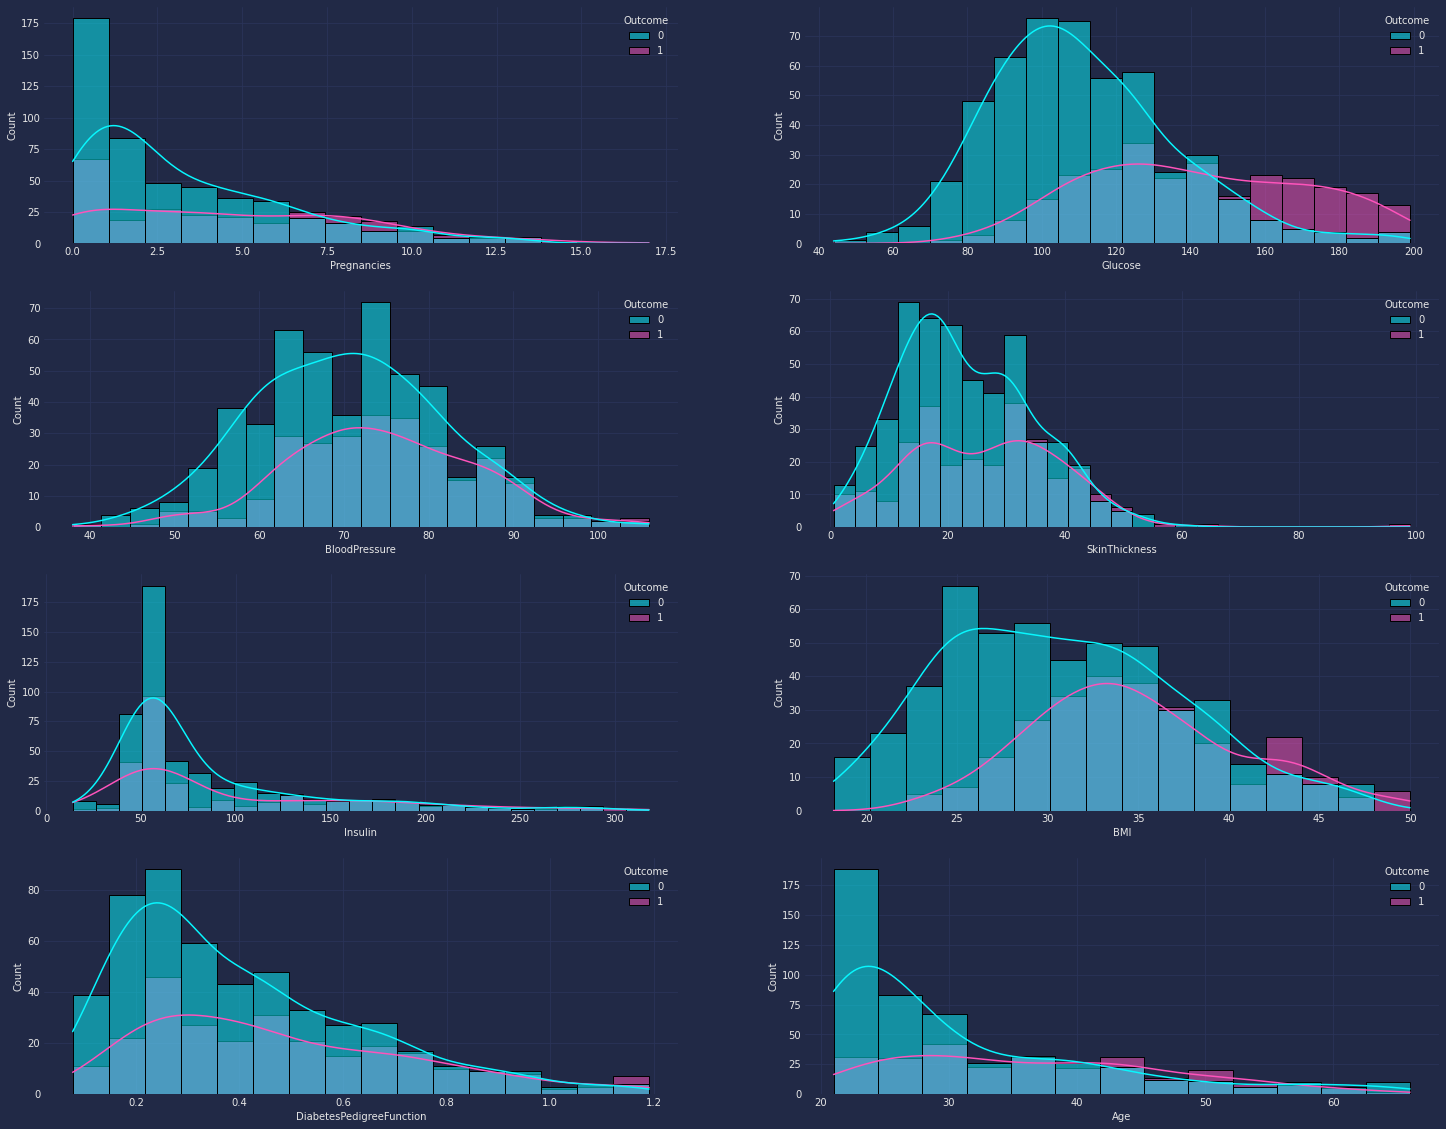

In [17]:
fig,axs = plt.subplots(4,2, figsize = (25, 20))

sns.histplot(data=df_nn, x="Pregnancies", kde=True, ax=axs[0, 0], hue='Outcome')
sns.histplot(data=df_nn, x="Glucose", kde=True, ax=axs[0, 1], hue='Outcome')
sns.histplot(data=df_nn, x="BloodPressure", kde=True, ax=axs[1, 0], hue='Outcome')
sns.histplot(data=df_nn, x="SkinThickness", kde=True, ax=axs[1, 1], hue='Outcome')
sns.histplot(data=df_nn, x="Insulin", kde=True, ax=axs[2, 0], hue='Outcome')
sns.histplot(data=df_nn, x="BMI", kde=True, ax=axs[2, 1], hue='Outcome')
sns.histplot(data=df_nn, x="DiabetesPedigreeFunction", kde=True, ax=axs[3, 0], hue='Outcome')
sns.histplot(data=df_nn, x="Age", kde=True, ax=axs[3, 1], hue='Outcome')

## Multivariate visualizations

In [18]:
fig = px.scatter_3d(df_nn, x='BMI', y='Glucose', z='Age', color="Outcome", color_continuous_scale=[(0,'#08F7FE'), (1,'#FE53BB')], template="plotly_dark")
fig.show()

In [19]:
fig = px.scatter_3d(df_nn, x='Pregnancies', y='BloodPressure', z='Age', color="Outcome", color_continuous_scale=[(0,'#08F7FE'), (1,'#FE53BB')], template="plotly_dark")
fig.show()

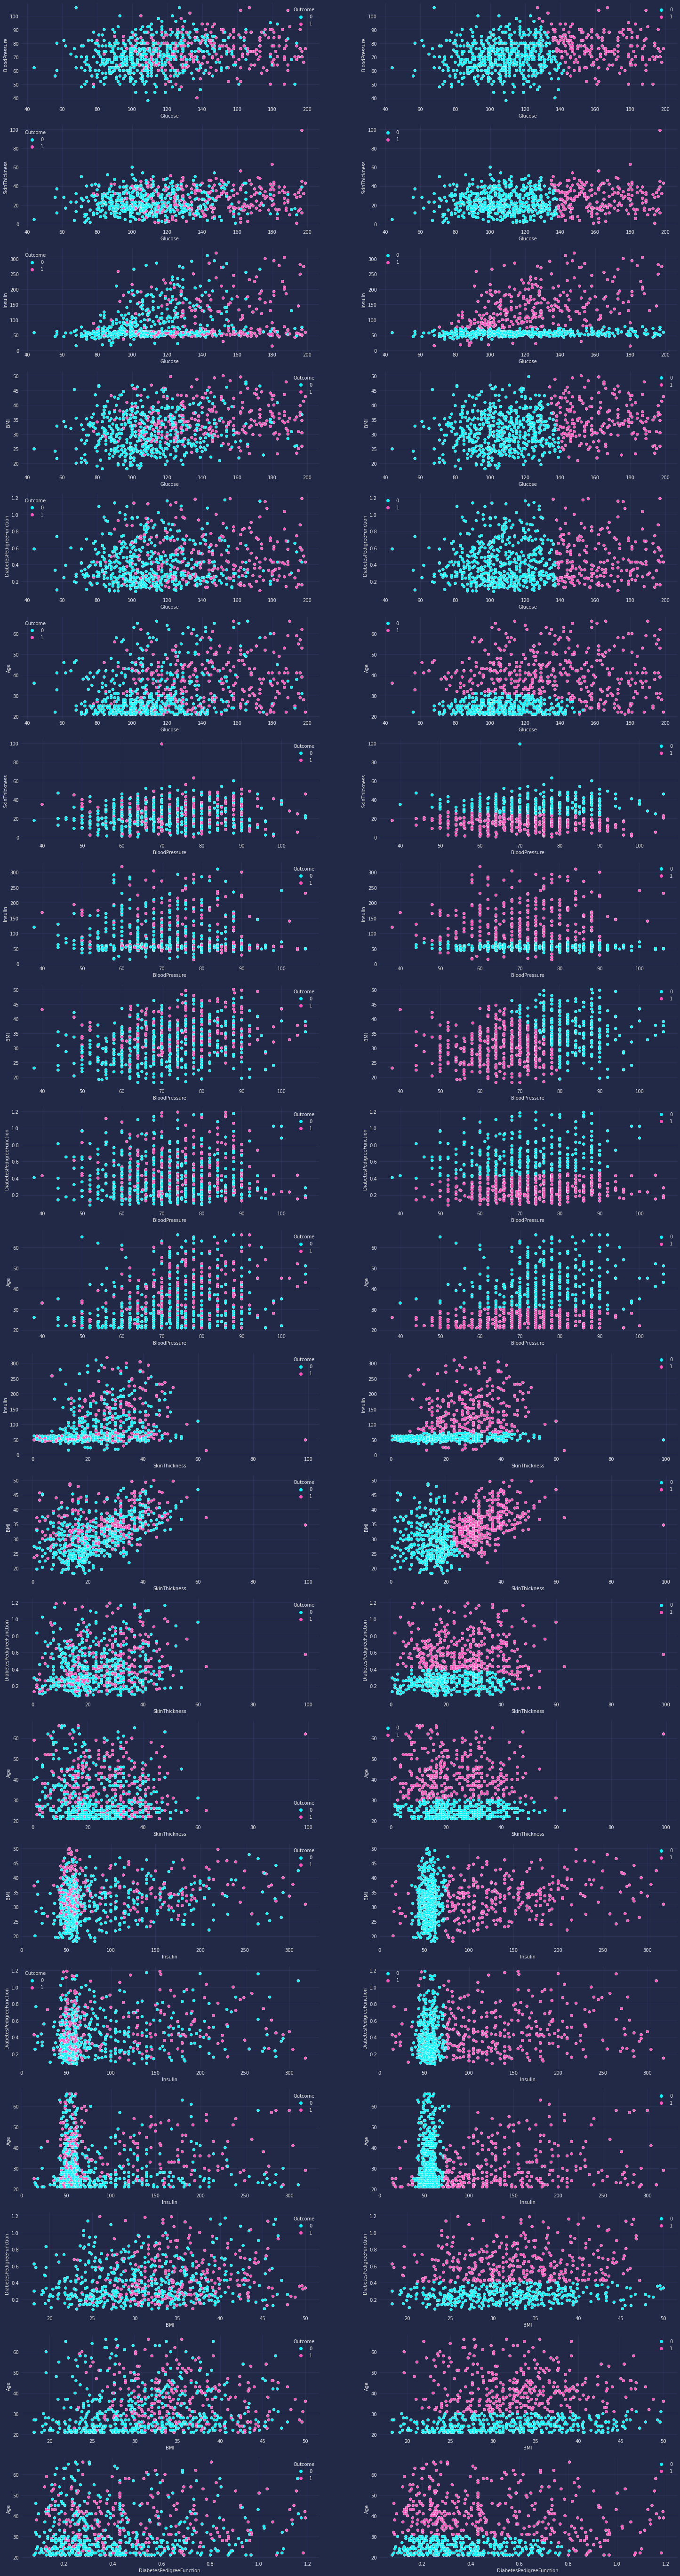

In [20]:
from sklearn.mixture import GaussianMixture

columns = df_nn.columns.tolist()
columns.remove("Outcome")
columns.remove("Pregnancies")
columns_cpy = columns.copy()

fig,axs = plt.subplots(21,2, figsize = (25, 100))
i = 0
for x in columns:
    columns_cpy.remove(x)
    for y in columns_cpy:
        outcome = GaussianMixture(n_components=2, max_iter=400, random_state=42).fit_predict(df_nn[[x, y]])
        df_nn[x+"_"+y] = outcome
        sns.scatterplot(data=df_nn, x=x, y=y, hue='Outcome', ax=axs[i, 0])
        sns.scatterplot(data=df_nn, x=x, y=y, hue=outcome, ax=axs[i, 1])
        i += 1

# 🧐 Looking for correlations:

<AxesSubplot:>

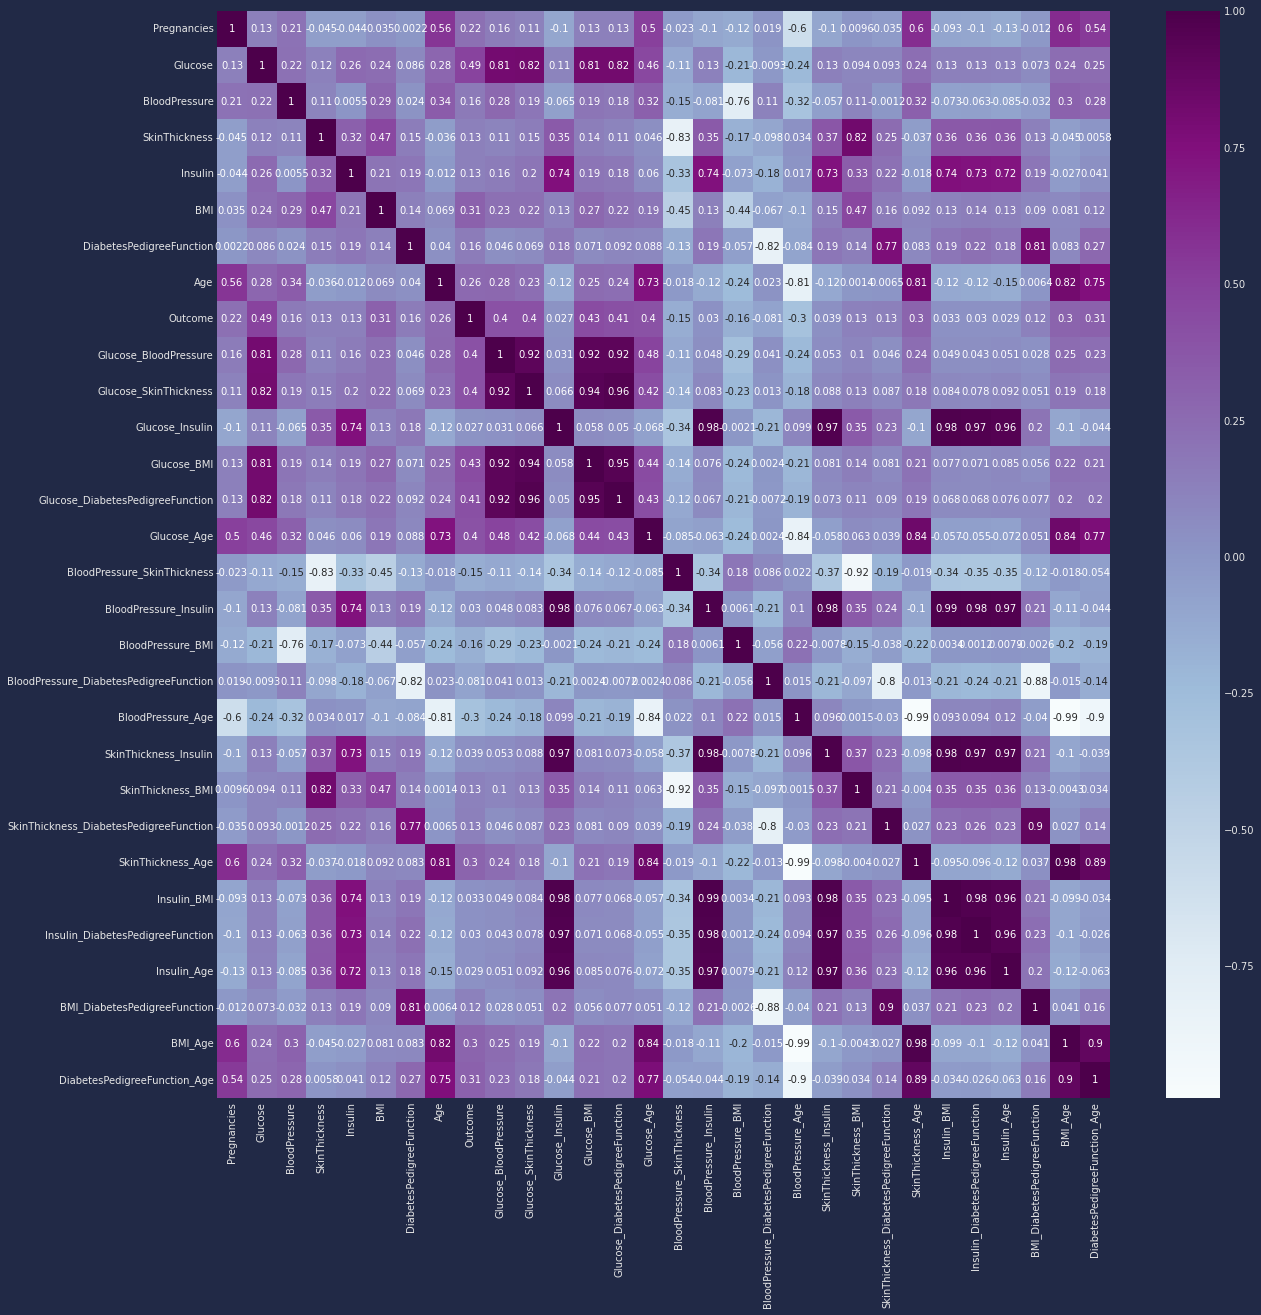

In [21]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(df_nn.corr(), annot=True, cmap='BuPu')

## Checking multicollinearity problem

In [22]:
def detect_VIF(df):
    df_ = df.copy()
    df_.drop(["Outcome"], axis=1, inplace=True)
    df_['intercept'] = 1
    
    while(True):
        df_vif = pd.DataFrame(columns=["Features", "VIF"])
        df_vif["Features"] = df_.columns
        df_vif["VIF"] = [variance_inflation_factor(df_.values, i) for i in range(len(df_.columns))]
        df_vif = df_vif[df_vif["Features"] != "intercept"].sort_values("VIF", ascending=False)
        if df_vif.iloc[0]["VIF"] > 5:
            df_.drop([df_vif.iloc[0]["Features"]], axis=1, inplace=True)
        else:
            next_ = False
            break
    df_.drop(["intercept"], axis=1, inplace=True)
    return df[df_.columns.tolist() + ["Outcome"]], df_vif
        
df_nn, df_vif = detect_VIF(df_nn)
df_vif

Features       VIF
11  BloodPressure_DiabetesPedigreeFunction  4.383071
6                 DiabetesPedigreeFunction  3.985056
15            DiabetesPedigreeFunction_Age  3.827136
9                              Glucose_Age  3.677842
13  SkinThickness_DiabetesPedigreeFunction  3.461551
3                            SkinThickness  3.356472
12                       SkinThickness_BMI  3.338293
1                                  Glucose  3.292525
8                              Glucose_BMI  3.216648
7                                      Age  3.034507
10                       BloodPressure_BMI  2.823816
2                            BloodPressure  2.689673
14                             Insulin_Age  2.333676
4                                  Insulin  2.259188
5                                      BMI  1.701258
0                              Pregnancies  1.584341

<AxesSubplot:>

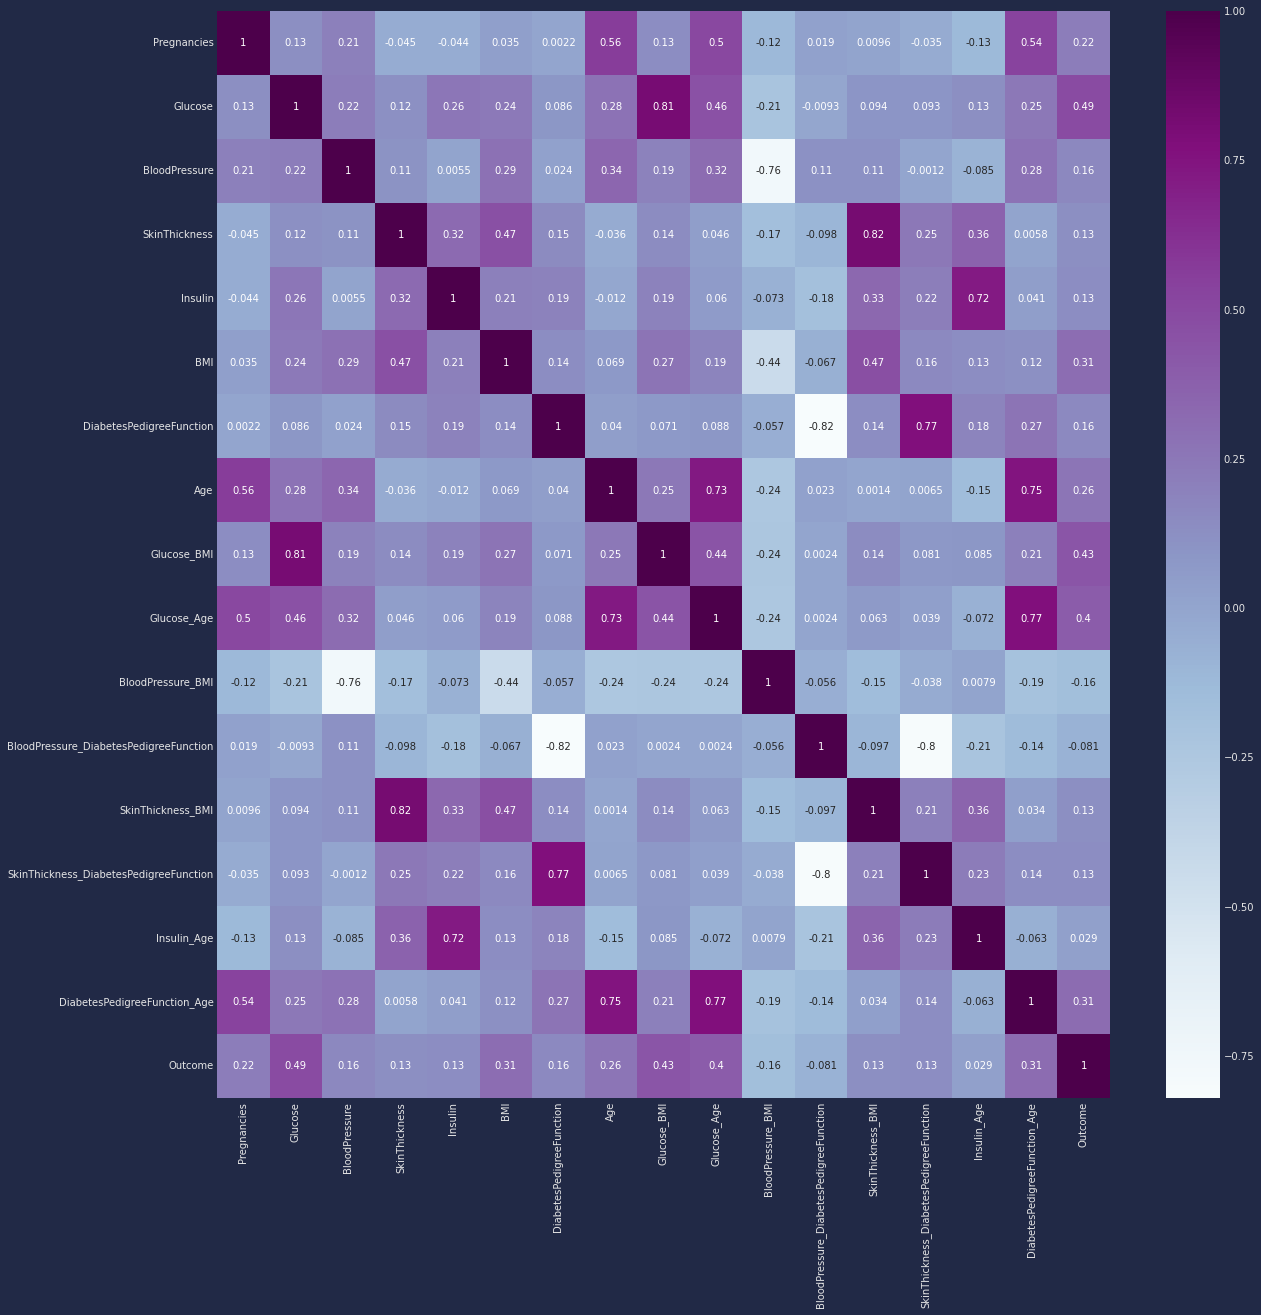

In [23]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(df_nn.corr(), annot=True, cmap='BuPu')

Important observations:

+ The features most correlate with the outcome are the glucose and IBM features, these features will be important for the prediction.
+ We can see that the numbers of pregnancies, age, glucose and IBM are important factors for building our model.
+ We see that the correlations between age and numbers of pregnancies and between IBM and skin thickness are the highest, these correlations can contribute with multicollinearity problems, i.e., these features could undermine the statistics significance of the independent variables.

# 🍕 Splitting dataset into training, test, and validation set

## Training, test and validation set

In [24]:
X = df_nn.drop(["Outcome"], axis=1)
y = df_nn["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# ⚖️ Dealing with imbalaced data

In [25]:
oversample = SMOTE(random_state=42, k_neighbors=10)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

1    424
0    424
Name: Outcome, dtype: int64

# 📏 Standardization and normalization

<AxesSubplot:xlabel='Insulin', ylabel='Count'>

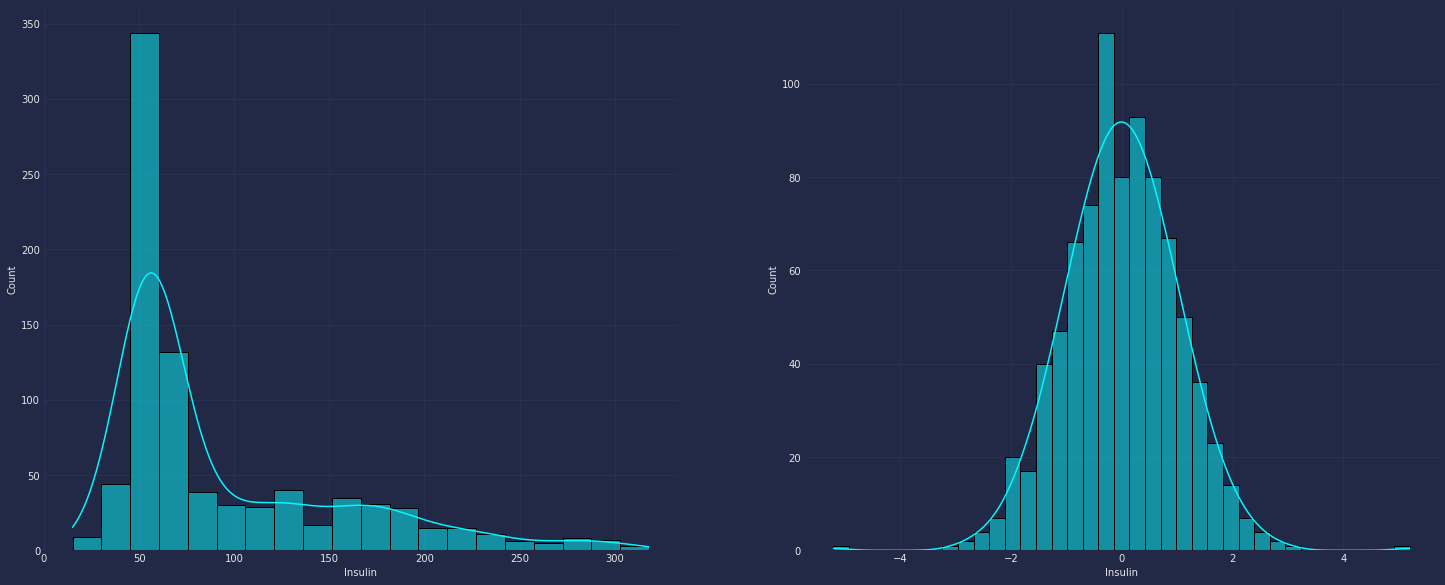

In [26]:
#sc = StandardScaler()
sc = QuantileTransformer(n_quantiles=len(X_train), output_distribution="normal", random_state=42)
mms = MinMaxScaler()

train_array = sc.fit_transform(X_train)
X_train_prep = pd.DataFrame(data=train_array, columns=X_train.columns)
#train_array = mms.fit_transform(X_train_prep)
#X_train_prep  = pd.DataFrame(data=train_array, columns=X_train.columns)

test_array = sc.transform(X_test)
X_test_prep = pd.DataFrame(data=test_array, columns=X_test.columns)
#test_array = mms.transform(X_test_prep)
#X_test_prep  = pd.DataFrame(data=test_array, columns=X_test.columns)

fig,axs = plt.subplots(1,2, figsize = (25, 10))
sns.histplot(data=X_train, x="Insulin", kde=True, ax=axs[0])
sns.histplot(data=X_train_prep, x="Insulin", kde=True, ax=axs[1])

# 🦾 Training of machine learning models

We will severals estimators to tasks of classification also we will use grid search to tuning models' hyperparameters, additionally we will evaluate their performance with confusion matrix where:

<table>
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Predicted</th>
    </tr>
    <tr>
        <td>Negative</td>
        <td>Positive</td>
    </tr>
    <tr>
        <th rowspan="2">Actual</th>
        <td>Negative</td>
        <td>TN</td>
        <td>FP</td>
    </tr>
    <tr>
        <td>Positive</td>
        <td>FN</td>
        <td>TP</td>
    </tr>
</table>

Taking into account that:
+ Case negative: Patients with normal conditions (NC)
+ Case positive: Patients with Diabetes
+ TN: The prediction tells us that the patient has NC when actually has NC.
+ TP: The prediction tells us that the patient has Diabetes when actually has Diabetes.
+ FN: The prediction tells us that the patient has NC when actually has Diabetes.
+ FP: The prediction tells us that the patient has Diabetes when actually has NC.

The worst case is a prediction of type FN, since we would be determining that the patient has normal condition, ignoring the possibility of Diabetes and exposing the patient to some damage in your health. For this reason, we will focus to reduce these type of predictions.
However, the amount of predictions of type FP shouldn't be too large since our model will be very useless.
The score that help us to analysis the amount of predictions of type FN is the recall where:

$Recall = \frac{TP}{TP + FN}\quad\text{if}\quad FN \rightarrow 0 \Longrightarrow Recall \rightarrow 1$

Also:

$Precision = \frac{TP}{TP + FP}\quad\text{if}\quad FP \rightarrow 0 \Longrightarrow Precision \rightarrow 1$

and

$F1 = \frac{TP}{TP + \frac{FN + FP}{2}}\quad\text{if}\quad FN, FP \rightarrow 0 \Longrightarrow F1 \rightarrow 1$

## Individual learners

### Logistic Regression

In [27]:
def get_best_estimator(estimator, params, X_train, y_train):
    grid = GridSearchCV(estimator(), params, scoring=["f1", "recall"], refit="f1", cv=15, verbose=1)
    grid.fit(X_train_prep, y_train)
    print(f"Best parameters: {grid.best_params_}")
    return grid

In [28]:
params = {"penalty": ["l2"],
         "tol": [7.5e-4, 5e-4, 1e-4],
         "C": [0.25, 0.5, 0.75, 1],
         "fit_intercept": [True, False],
         "class_weight": ["balanced"],
         "solver": ["lbfgs", "liblinear", "saga"],
         "max_iter": [100, 200, 300]}
lr = get_best_estimator(LogisticRegression, params, X_train_prep, y_train)

Fitting 15 folds for each of 216 candidates, totalling 3240 fits
Best parameters: {'C': 0.75, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.00075}


In [29]:
y_test_lr = lr.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_lr, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.849315  0.815789  0.832215   76.000000
1              0.674419  0.725000  0.698795   40.000000
accuracy       0.784483  0.784483  0.784483    0.784483
macro avg      0.761867  0.770395  0.765505  116.000000
weighted avg   0.789006  0.784483  0.786208  116.000000

<AxesSubplot:>

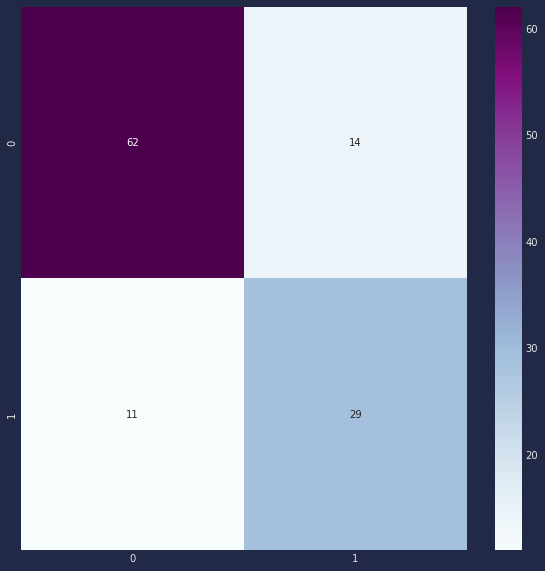

In [30]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_lr)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### SVM (Vector Support Machines)

In [31]:
params = {"C": [0.25, 0.5, 0.75, 1],
          "kernel": ["linear", "rbf", "sigmoid"],
          "gamma": [0.025, 0.05, 0.1],
          "tol": [5e-5, 1e-4, 5e-4],
          "class_weight": ["balanced"]}
svc = get_best_estimator(SVC, params, X_train_prep, y_train)

Fitting 15 folds for each of 108 candidates, totalling 1620 fits
Best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf', 'tol': 5e-05}


In [32]:
y_test_svc = svc.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_svc, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.761194  0.671053  0.713287   76.000000
1              0.489796  0.600000  0.539326   40.000000
accuracy       0.646552  0.646552  0.646552    0.646552
macro avg      0.625495  0.635526  0.626306  116.000000
weighted avg   0.667608  0.646552  0.653300  116.000000

<AxesSubplot:>

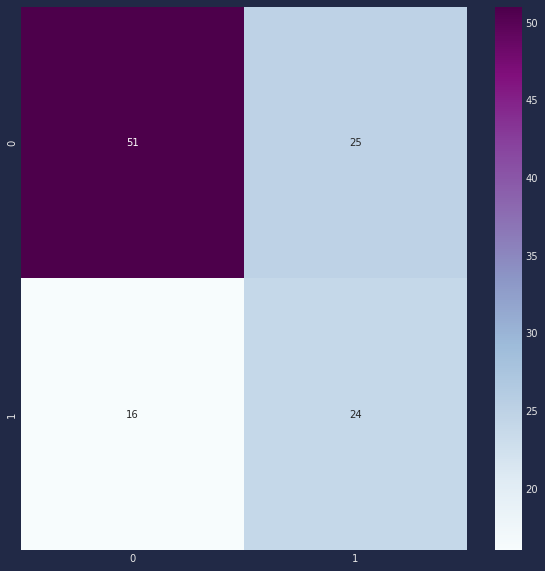

In [33]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_svc)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### K-Nearest Neighbors

In [34]:
params = {"n_neighbors": [3, 4, 5],
          "weights": ["uniform", "distance", None],
          "algorithm": ["auto"],
          "leaf_size": [30, 40, 50]
         }

knn = get_best_estimator(KNeighborsClassifier, params, X_train_prep, y_train)

Fitting 15 folds for each of 27 candidates, totalling 405 fits
Best parameters: {'algorithm': 'auto', 'leaf_size': 30, 'n_neighbors': 4, 'weights': 'distance'}


In [35]:
y_test_knn = knn.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_knn, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.800000  0.736842  0.767123   76.000000
1              0.565217  0.650000  0.604651   40.000000
accuracy       0.706897  0.706897  0.706897    0.706897
macro avg      0.682609  0.693421  0.685887  116.000000
weighted avg   0.719040  0.706897  0.711098  116.000000

<AxesSubplot:>

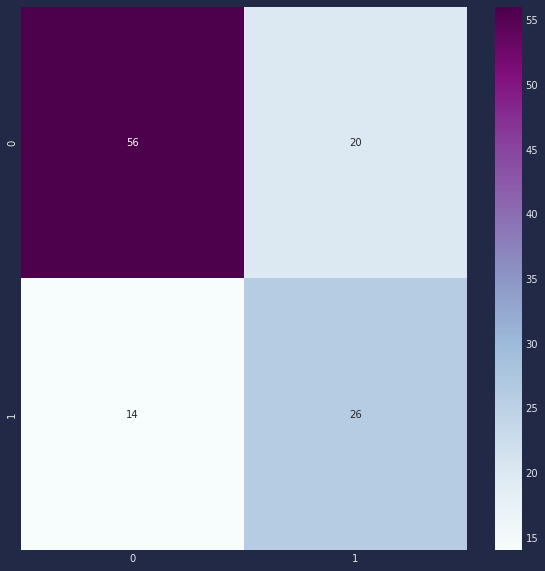

In [36]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_knn)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### Decision Tree

In [37]:
params = {"criterion": ["gini", "entropy"],
          "splitter": ["best", "random"],
          "max_depth": [10, 15, 20],
          "max_features": [None, "auto", "sqrt", "log2"],
          "class_weight": [None, "balanced"],
          "random_state": [42]}
dt = get_best_estimator(DecisionTreeClassifier, params, X_train_prep, y_train)

Fitting 15 folds for each of 96 candidates, totalling 1440 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'random_state': 42, 'splitter': 'random'}


In [38]:
y_test_dt = dt.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_dt, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.780822  0.750000  0.765101   76.000000
1              0.558140  0.600000  0.578313   40.000000
accuracy       0.698276  0.698276  0.698276    0.698276
macro avg      0.669481  0.675000  0.671707  116.000000
weighted avg   0.704035  0.698276  0.700691  116.000000

<AxesSubplot:>

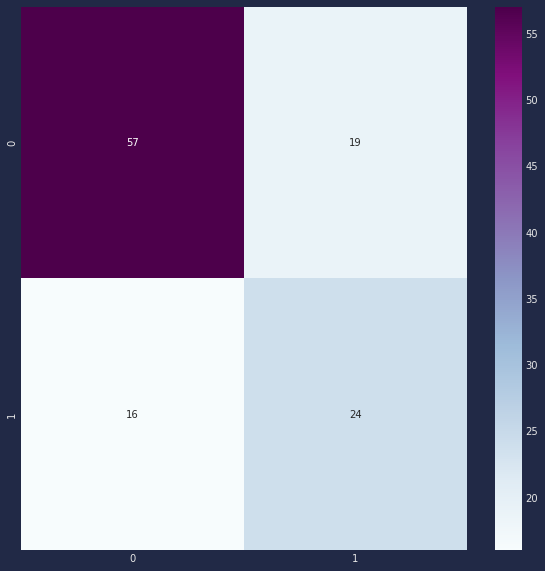

In [39]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_dt)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

## Ensemble Learning
This technique consist of making use of several algorithms of machine learning to obtain an ensemble predictions that is relatively better than the predictions of individual learners.

### Bagging with Random Forest:
Bagging is a technique that consist of combining several equal machine learning models where each model uses different subsets of the training set, in this way we compensate the error in the prediccion between models, obtaining a final model that has an output with less variance in comparison with the output of the individual models.

<img src="https://www.simplilearn.com/ice9/free_resources_article_thumb/Bagging.PNG">

The Random Forest algorithm is an ensemble implemented with Baggin, where hundreds of decision trees are used to determinate the output of the final model.

In [40]:
params = {"n_estimators": [100, 150, 200, 250, 300],
          "criterion": ["entropy"],
          "max_depth": [16, 17, 18],
          "class_weight": [None, "balanced"],
          "bootstrap": [True],
          "random_state": [42]}
rf = get_best_estimator(RandomForestClassifier, params, X_train_prep, y_train)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Best parameters: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 300, 'random_state': 42}


In [41]:
y_test_rf = rf.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_rf, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.866667  0.855263  0.860927   76.000000
1              0.731707  0.750000  0.740741   40.000000
accuracy       0.818966  0.818966  0.818966    0.818966
macro avg      0.799187  0.802632  0.800834  116.000000
weighted avg   0.820129  0.818966  0.819484  116.000000

<AxesSubplot:>

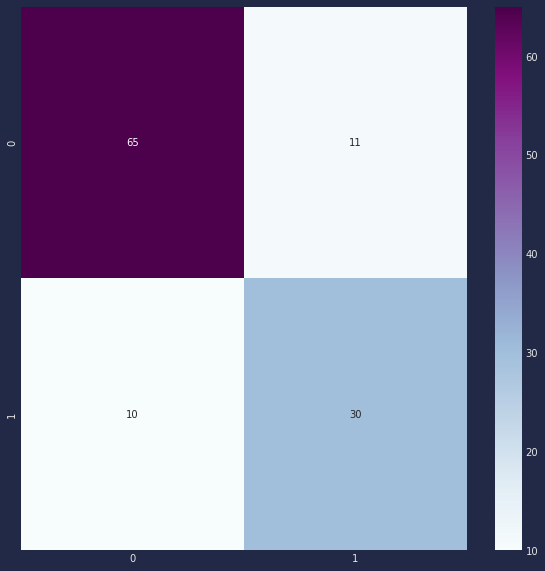

In [42]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_rf)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### Boosting with AdaBoost and XGBoost

Boosting is an ensemble modeling technique that attempts to build a strong classifier from the number of weak classifiers. It is done by building a model by using weak models in series. Firstly, a model is built from the training data. Then the second model is built which tries to correct the errors present in the first model. This procedure is continued and models are added until either the complete training data set is predicted correctly or the maximum number of models are added. 

<img src="https://miro.medium.com/v2/resize:fit:850/0*KYszvMnr3nCtjaGy.png">

#### AdaBoost

In [43]:
params = {"base_estimator":[dt.best_estimator_],
          "n_estimators": [100, 200, 300, 500],
          "learning_rate": [0.01, 0.005, 0.001],
          "algorithm": ["SAMME", "SAMME.R"],
          "random_state": [42]}
ada = get_best_estimator(AdaBoostClassifier, params, X_train_prep, y_train)

Fitting 15 folds for each of 24 candidates, totalling 360 fits
Best parameters: {'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=42,
                       splitter='random'), 'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 42}


In [44]:
y_test_ada = ada.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_ada, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.783784  0.763158  0.773333   76.000000
1              0.571429  0.600000  0.585366   40.000000
accuracy       0.706897  0.706897  0.706897    0.706897
macro avg      0.677606  0.681579  0.679350  116.000000
weighted avg   0.710558  0.706897  0.708517  116.000000

<AxesSubplot:>

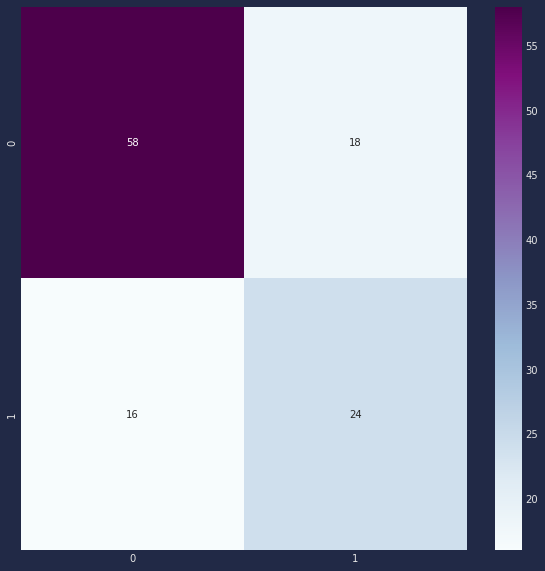

In [45]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_ada)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

#### XGBBoost

In [46]:
params={"n_estimators":[2, 3, 4, 5],
       "max_leaves":[0],
        "learning_rate":[0.01, 0.001, 0.0001],
        "objective":['binary:logistic'],
        "gamma": [1, 5, 10, 15]
       }
xgb = get_best_estimator(XGBClassifier, params, X_train_prep, y_train)

Fitting 15 folds for each of 48 candidates, totalling 720 fits
Best parameters: {'gamma': 15, 'learning_rate': 0.001, 'max_leaves': 0, 'n_estimators': 2, 'objective': 'binary:logistic'}


In [47]:
y_test_xgb = xgb.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_xgb, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.929825  0.697368  0.796992   76.000000
1              0.610169  0.900000  0.727273   40.000000
accuracy       0.767241  0.767241  0.767241    0.767241
macro avg      0.769997  0.798684  0.762133  116.000000
weighted avg   0.819599  0.767241  0.772951  116.000000

<AxesSubplot:>

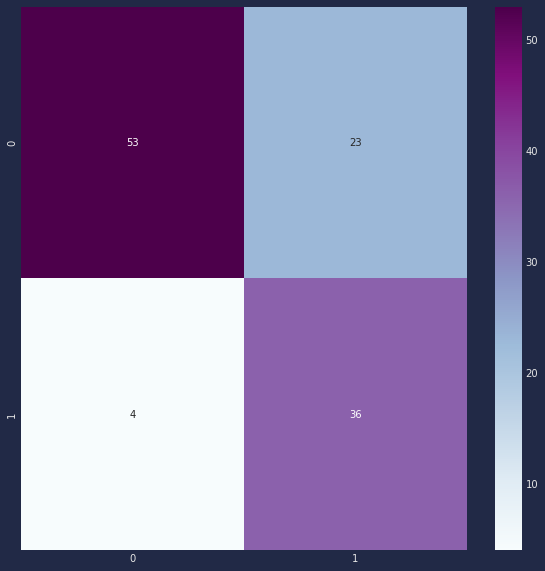

In [48]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_xgb)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### Stacking with StackingClassifier

Stacking is a technique that consist exactly in the stacking of several machine learning models, them can be different or no, stacking consist basically of using the output of several models as inputs to several other models. This stack can be single or multilayers.

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200713234827/mlxtend.PNG">

In [49]:
estimators = [("lr", LogisticRegression(C=0.25, class_weight='balanced', max_iter=30, solver='liblinear', tol=0.00075)), 
              ("svc", SVC(C=0.25, class_weight='balanced', gamma=5, tol=0.0005)), 
              ("dt", DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)),
              ("rf", RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=4, n_estimators=400, oob_score=recall_score, random_state=42))]

stack = StackingClassifier(estimators=estimators, cv=15)
stack.fit(X_train_prep, y_train)

StackingClassifier(cv=15,
                   estimators=[('lr',
                                LogisticRegression(C=0.25,
                                                   class_weight='balanced',
                                                   max_iter=30,
                                                   solver='liblinear',
                                                   tol=0.00075)),
                               ('svc',
                                SVC(C=0.25, class_weight='balanced', gamma=5,
                                    tol=0.0005)),
                               ('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=4,
                                                       random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       

In [50]:
y_test_stack = stack.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_stack, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.845070  0.789474  0.816327   76.000000
1              0.644444  0.725000  0.682353   40.000000
accuracy       0.767241  0.767241  0.767241    0.767241
macro avg      0.744757  0.757237  0.749340  116.000000
weighted avg   0.775889  0.767241  0.770129  116.000000

<AxesSubplot:>

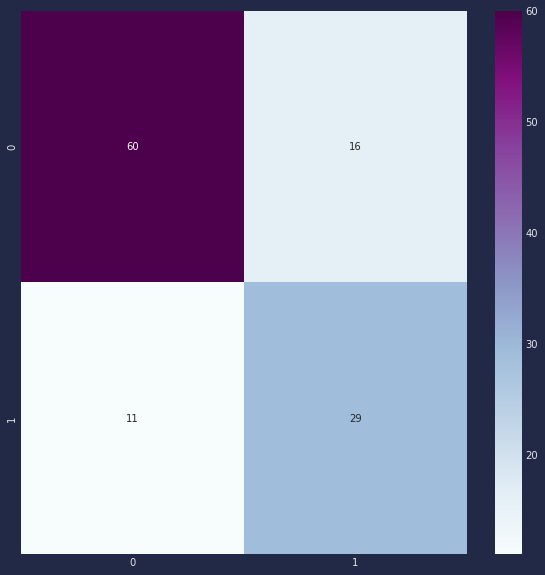

In [51]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_stack)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

### Voting with VotingClassifier
A voting classifier is a machine learning estimator that trains various base models or estimators and predicts on the basis of aggregating the findings of each base estimator. The aggregating criteria can be combined decision of voting for each estimator output. The voting criteria can be of two types:

<img src="https://editor.analyticsvidhya.com/uploads/41161hard%20vs%20soft.png">


+ **Hard Voting**: Voting is calculated on the predicted output class.
+ **Soft Voting**: Voting is calculated on the predicted probability of the output class.

#### Soft Voting

In [52]:
estimators = [("lr", LogisticRegression(C=0.25, class_weight='balanced', max_iter=30, solver='liblinear', tol=0.00075)), 
              ("svc", SVC(C=0.25, class_weight='balanced', gamma=5, tol=0.0005, probability=True)), 
              ("dt", DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)),
              ("rf", RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=4, n_estimators=400, oob_score=recall_score, random_state=42))]

vote = VotingClassifier(estimators=estimators, voting="soft")
vote.fit(X_train_prep, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.25,
                                                 class_weight='balanced',
                                                 max_iter=30,
                                                 solver='liblinear',
                                                 tol=0.00075)),
                             ('svc',
                              SVC(C=0.25, class_weight='balanced', gamma=5,
                                  probability=True, tol=0.0005)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                   

In [53]:
y_test_vote = vote.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_vote, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.855072  0.776316  0.813793   76.000000
1              0.638298  0.750000  0.689655   40.000000
accuracy       0.767241  0.767241  0.767241    0.767241
macro avg      0.746685  0.763158  0.751724  116.000000
weighted avg   0.780323  0.767241  0.770987  116.000000

<AxesSubplot:>

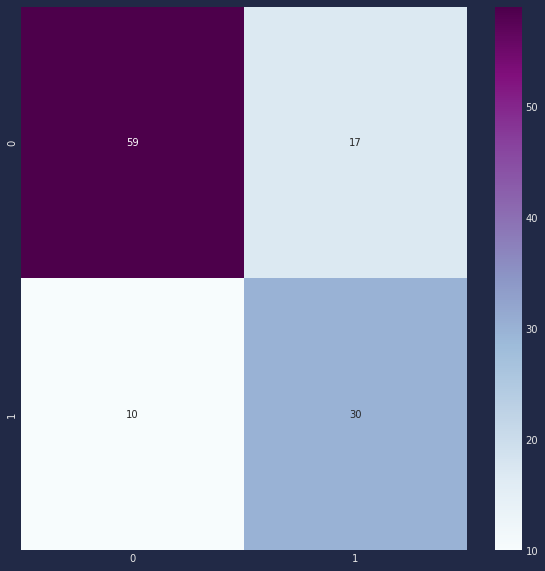

In [54]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_vote)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

#### Hard Voting

In [55]:
estimators = [("lr", LogisticRegression(C=0.25, class_weight='balanced', max_iter=30, solver='liblinear', tol=0.00075)), 
              ("svc", SVC(C=0.25, class_weight='balanced', gamma=5, tol=0.0005, probability=True)), 
              ("dt", DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)),
              ("rf", RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=4, n_estimators=400, oob_score=recall_score, random_state=42))]

vote_h = VotingClassifier(estimators=estimators, voting="hard")
vote_h.fit(X_train_prep, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.25,
                                                 class_weight='balanced',
                                                 max_iter=30,
                                                 solver='liblinear',
                                                 tol=0.00075)),
                             ('svc',
                              SVC(C=0.25, class_weight='balanced', gamma=5,
                                  probability=True, tol=0.0005)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     criterion='entropy',
                   

In [56]:
y_test_vote_h = vote_h.predict(X_test_prep)
pd.DataFrame(data=classification_report(y_test, y_test_vote_h, digits=6, output_dict=True)).transpose()

precision    recall  f1-score     support
0              0.842105  0.842105  0.842105   76.000000
1              0.700000  0.700000  0.700000   40.000000
accuracy       0.793103  0.793103  0.793103    0.793103
macro avg      0.771053  0.771053  0.771053  116.000000
weighted avg   0.793103  0.793103  0.793103  116.000000

<AxesSubplot:>

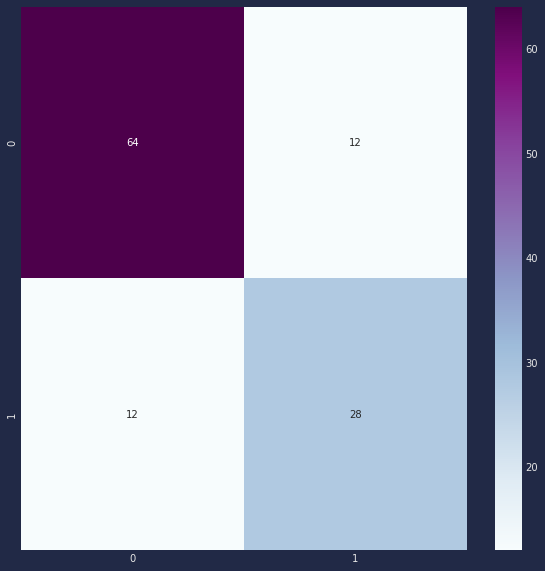

In [57]:
fig = plt.figure(figsize=(10,10))

conf_mx = confusion_matrix(y_test, y_test_vote_h)
sns.heatmap(conf_mx, annot=True, fmt='', cmap='BuPu')

# 📣 Conclusion
We can see how an Ensemble Learning model obtains better results for this problem than if we approached it with individual estimators, it should be noted that the result could improve or worsen by modifying the hyperparameters or simply due to changes in the preprocessing of the dataset, for example, eliminating characteristics that we believe do not influence the prediction when in fact it does.

In [58]:
def print_scores(y, y_pred, pp_scores=False):
    ac, pr, rc, f1 = accuracy_score(y, y_pred)*100, precision_score(y, y_pred)*100, recall_score(y, y_pred)*100, f1_score(y, y_pred, average='weighted')*100
    if pp_scores == True:
        print(f"Accuracy:{ac}")
        print(f"Precision:{pr}")
        print(f"Recall:{rc}")
        print(f"F1-score:{f1}")
    return {'Accuracy': ac, 'Precision':pr, 'Recall':rc, 'F1-score':f1}

lr_scores = print_scores(y_test, y_test_lr)
svc_scores = print_scores(y_test, y_test_svc)
knn_scores = print_scores(y_test, y_test_knn)
dt_scores = print_scores(y_test, y_test_dt)
rf_scores = print_scores(y_test, y_test_rf)
ada_scores = print_scores(y_test, y_test_ada)
xgb_scores = print_scores(y_test, y_test_xgb)
stack_scores = print_scores(y_test, y_test_stack)
vote_scores = print_scores(y_test, y_test_vote)
vote_h_scores = print_scores(y_test, y_test_vote_h)

scores = pd.DataFrame(data=[list(lr_scores.values()),
                            list(svc_scores.values()),
                            list(knn_scores.values()),
                            list(dt_scores.values()),
                            list(rf_scores.values()),
                            list(ada_scores.values()),
                            list(xgb_scores.values()),
                            list(stack_scores.values()),
                            list(vote_scores.values()),
                            list(vote_h_scores.values()),
                           ], columns=list(lr_scores.keys()))

scores = scores.transpose()
scores = scores.rename(columns={0:"Linear Regression",
                                1:"C-Support Vector",
                                2:"K-Nearest Neighbors",
                                3:"Decission Tree",
                                4:"Random Forest",
                                5:"AdaBoost Classifier",
                                6:"XGBoost Classifier",
                                7:"Stacking Classifier",
                                8:"Voting Classifier (soft)",
                                9:"Voting Classifier (hard)",
                               })
scores.style.highlight_max(color = 'green', axis = 1)